In [1]:
	import tensorflow as tf
	tf.__version__
	import numpy as np

In [2]:
!pip install opencv-contrib-python

In [3]:
import cv2
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
from imutils import paths
import time
import os

In [4]:
print(cv2.__version__)

4.10.0


In [5]:
!pip install matplotlib

In [6]:
from google.colab import drive

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


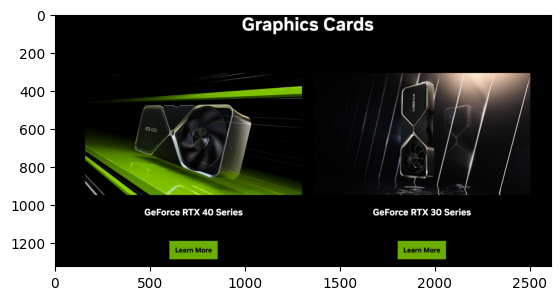

In [8]:
import matplotlib.pyplot as plt
img_path = '/content/drive/MyDrive/images/rtx.png'
img1 = cv2.imread(img_path)
plt.imshow(img1[:,:,::-1])
plt.show()

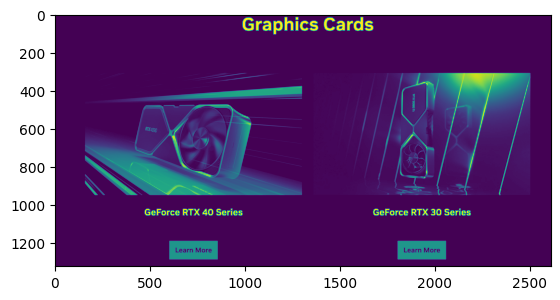

In [9]:
img_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray)
plt.show()

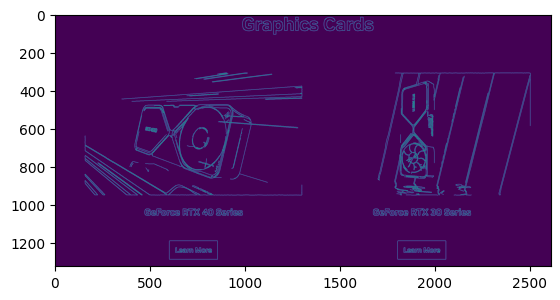

In [10]:
edged = cv2.Canny(img_gray,75,200)
plt.imshow(edged)
plt.show()

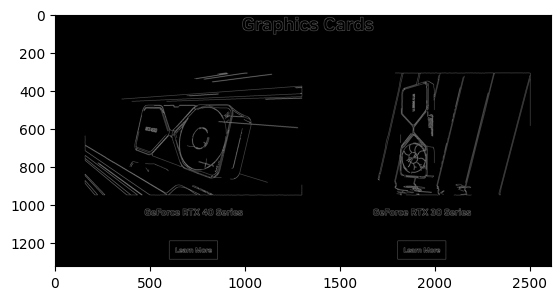

In [11]:
rgb_img1 = cv2.cvtColor(edged, cv2.COLOR_GRAY2RGB)
plt.imshow(rgb_img1)
plt.show()

In [12]:
!git clone https://github.com/dilhelh/opencv-text-detection.git

Cloning into 'opencv-text-detection'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11 (from 1)
Receiving objects: 100% (11/11), 86.25 MiB | 23.48 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [13]:
!python /content/opencv-text-detection/text_detection.py --image /content/opencv-text-detection/images/lebron_james.jpg \
	--east /content/opencv-text-detection/frozen_east_text_detection.pb

[INFO] loading EAST text detector...
[INFO] text detection took 1.060754 seconds
qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr/local/lib/python3.10/dist-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb.



In [14]:
!wget -q https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/releases/download/v0.11.0/coco_text_100.tar.gz
!tar xf coco_text_100.tar.gz

In [15]:
IMAGE_LIST = list(paths.list_images('/content/coco_text_100'))
IMG_SIZE = 320

In [16]:
def representative_dataset_gen():
    for image_path in IMAGE_LIST:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype("float32")
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean
        image = np.expand_dims(image, axis=0)
        yield [image]

In [17]:
quantization = "float16" #@param ["dr", "int8", "float16"]
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file='/content/opencv-text-detection/frozen_east_text_detection.pb',
    input_arrays=['input_images'],
    output_arrays=['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'],
    input_shapes={'input_images': [1, 320, 320, 3]}
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

if quantization=="float16":
    converter.target_spec.supported_types = [tf.float16]
elif quantization=="int8":
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
open('east_model_{}.tflite'.format(quantization), 'wb').write(tflite_model)

48133756

In [18]:
!ls -lh *.tflite
!ls -lh /content/opencv-text-detection/frozen_east_text_detection.pb

-rw-r--r-- 1 root root 46M Oct 16 07:16 east_model_float16.tflite
-rw-r--r-- 1 root root 93M Oct 16 07:14 /content/opencv-text-detection/frozen_east_text_detection.pb


In [19]:
def preprocess_image(image):
    orig = image.copy()
    (H, W) = image.shape[:2]
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    image = image.astype("float32")
    mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
    image -= mean
    image = np.expand_dims(image, 0)

    return image, orig, rW, rH

In [20]:
image, orig, rW, rH = preprocess_image(rgb_img1)

In [21]:
def perform_inference(tflite_path, preprocessed_image):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    input_details = interpreter.get_input_details()

    if input_details[0]["dtype"]==np.uint8:
        print("Integer quantization!")
        input_scale, input_zero_point = input_details[0]["quantization"]
        preprocessed_image = preprocessed_image / input_scale + input_zero_point
    preprocessed_image = preprocessed_image.astype(input_details[0]["dtype"])
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    start = time.time()
    interpreter.invoke()
    print(f"Inference took: {time.time()-start} seconds")

    scores = interpreter.tensor(
        interpreter.get_output_details()[0]['index'])()
    geometry = interpreter.tensor(
        interpreter.get_output_details()[1]['index'])()

    return scores, geometry

In [22]:
quantization = "float16" #@param ["dr", "int8", "float16"]
scores, geometry = perform_inference(tflite_path=f'east_model_{quantization}.tflite',
                                     preprocessed_image=image)


Inference took: 0.558673620223999 seconds


In [23]:
scores.shape, geometry.shape

((1, 80, 80, 1), (1, 80, 80, 5))

In [24]:
scores = np.transpose(scores, (0, 3, 1, 2))
geometry = np.transpose(geometry, (0, 3, 1, 2))
scores.shape, geometry.shape

((1, 1, 80, 80), (1, 5, 80, 80))

In [25]:
!sudo apt install tesseract-ocr libtesseract-dev
!pip -q install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev tesseract-ocr
  tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,560 kB of archives.
After this operation, 31.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.1 [582 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:5 http://arc

In [26]:
import pytesseract

In [27]:
def post_process(score, geo, ratioW, ratioH, original):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = score.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = score[0, 0, y]
        xData0 = geo[0, 0, y]
        xData1 = geo[0, 1, y]
        xData2 = geo[0, 2, y]
        xData3 = geo[0, 3, y]
        anglesData = geo[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.5:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    # loop over the bounding boxes and extarct texts
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * ratioW)
        startY = int(startY * ratioH)
        endX = int(endX * ratioW)
        endY = int(endY * ratioH)
        # draw the bounding box on the image
        cv2.rectangle(original, (startX, startY), (endX, endY), (0, 255, 0), 2)
        # Split the bounding box and extract the text from it
        roi = original[startY:endY, startX:endX]
        text = pytesseract.image_to_string(roi)
        # Print OCR extracted text
        print(text)
    # show the output image
    cv2_imshow(original)

a Learn More

a Learn More

’ 30 Series

GeForce RT

GeForce RTX

‘apr

RTX 40 Series



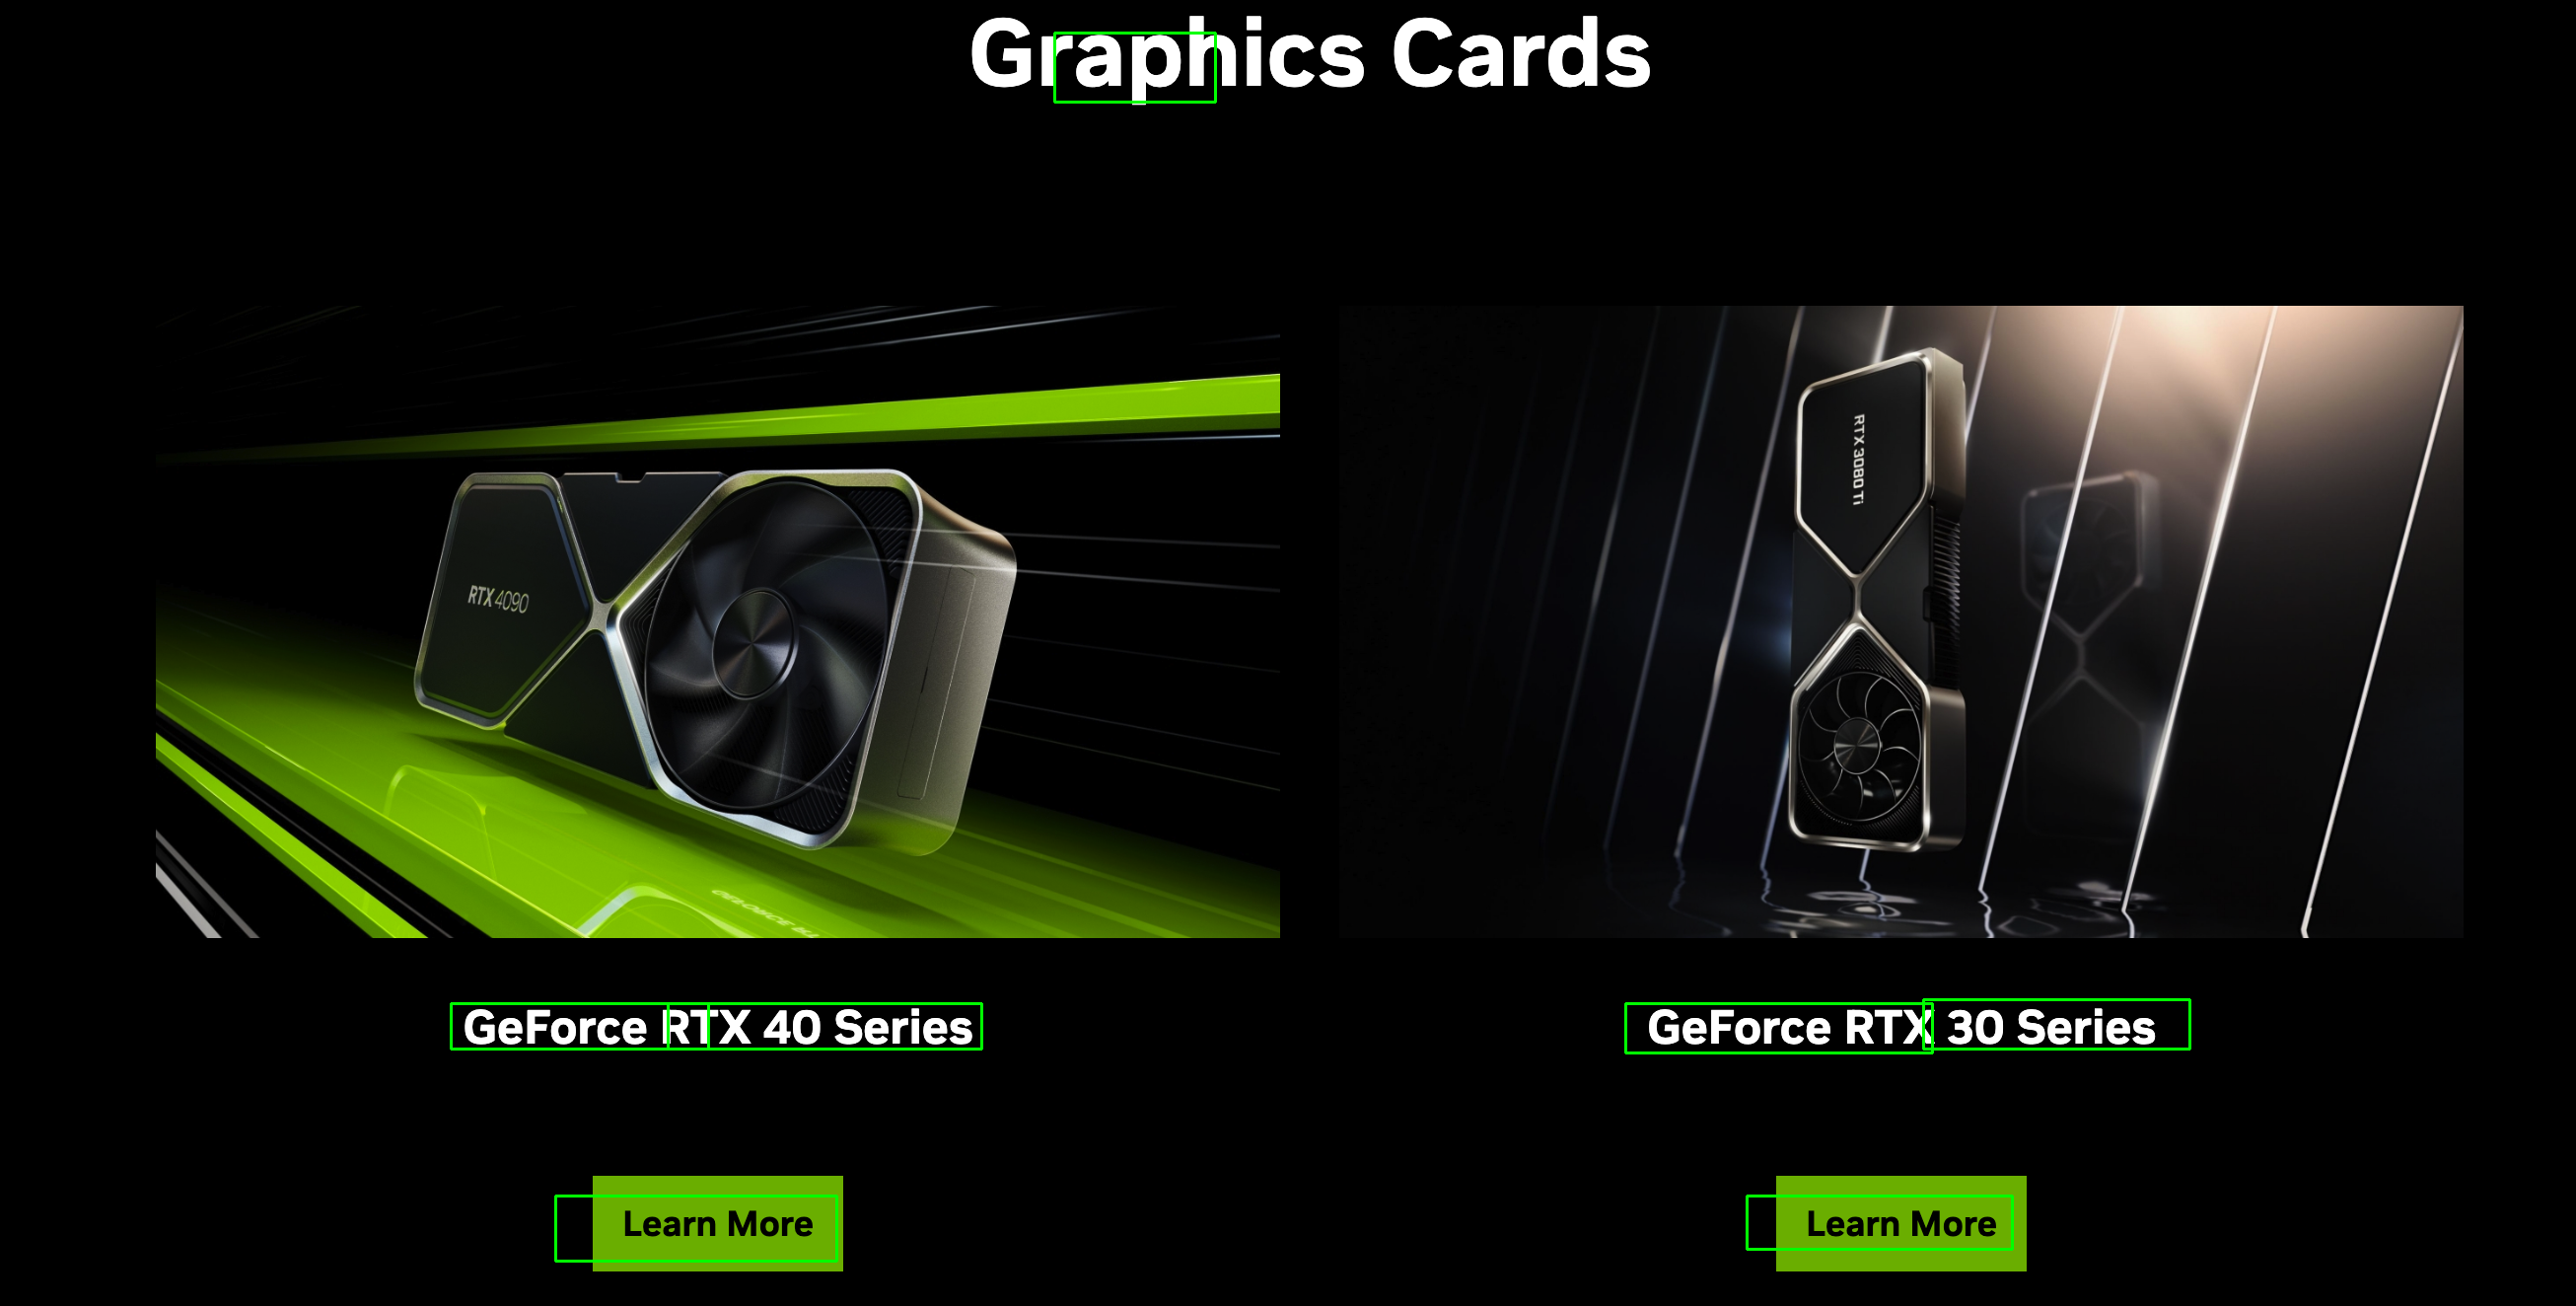

In [28]:
original = img1
post_process(scores, geometry, rW, rH, original)